GC. June 1-5

Somewhat following the  "master notebook" (Sept 2024) by Tom, but combining some easier examples as shown by Alin. 

Not sure if all the caveats re: the metadata of the BZJOM datasets are still true, or not. 

In [1]:
## MOSTLY STANDARD PYTHON PACKAGES IN USE AVAILABLE FROM STANDARD REPOSITORIES

import dkist
print("DKIST version: ",dkist.__version__)
import asdf
print("ASDF version: ",asdf.__version__)

import sunpy
print("sunpy version:", sunpy.__version__)
import dask
from dask.diagnostics import ProgressBar
import psutil 

DKIST version:  1.13.0
ASDF version:  4.2.0
sunpy version: 6.1.1


In [2]:
## MOSTLY STANDARD PYTHON PACKAGES IN USE AVAILABLE FROM STANDARD REPOSITORIES
import os
import numpy as np
import glob
import warnings
from tqdm import tqdm
from tqdm.auto import trange
from datetime import datetime
from scipy import ndimage,signal
from scipy.optimize import differential_evolution, minimize
import multiprocessing
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.wcs import WCS
import sunpy.map
from sunpy.coordinates import sun

In [3]:
### PLOTTING TOOLS
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm
%matplotlib inline
plt.rcParams["figure.dpi"] = 180
#### Change to widget backend if desired: %matplotlib widget
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'

In [4]:
import hvpy ## helioviewer api for pulling quick context images from SDO/AIA (JPEG2000 compressed)
#from numba import njit ## Just in time compiler for faster code snippets -- dependency can be removed it njit decorators below are removed

ModuleNotFoundError: No module named 'hvpy'

hvpy gives me trouble. I updated it this morning and everything seems in order (if I try to update it again, it tells me everything is already there). But maybe there is a problem with this newest version? maybe I should just skip it for now and see what I can do without

In [5]:
!pip install hvpy

  Using cached hvpy-1.1.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached pydantic-2.11.5-py3-none-any.whl.metadata (67 kB)
  Using cached pydantic_settings-2.9.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
Using cached hvpy-1.1.0-py3-none-any.whl (44 kB)
Using cached pydantic-2.11.5-py3-none-any.whl (444 kB)
Using cached pydantic_core-2.33.2-cp313-cp313-macosx_11_0_arm64.whl (1.8 MB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached pydantic_settings-2.9.1-py3-none-any.whl (44 kB)
Using cached python_dotenv-1.1.0-py3-none-any.whl (20 kB)
Using cached typing_inspection-0.4.1-py3-none-any.whl (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [hvpy]4/7 [pydantic]


In [6]:
!pip show hvpy

Name: hvpy
Version: 1.1.0
Summary: Helioviewer Python API Wrapper
Home-page: https://helioviewer.org/
Author: The Helioviewer Project
Author-email: contact@helioviewer.org
License: BSD 2-Clause
Location: /Users/gcauzzi/anaconda3/envs/dkist_spd2025/lib/python3.13/site-packages
Requires: pydantic, pydantic-settings, requests
Required-by: 


In [ ]:
#Now I try to read the ASDF file, using the commands I used for VBI

In [7]:
import dkist.net
import astropy.units as u
from sunpy.net import Fido, attrs as a

In [8]:
res = Fido.search(a.dkist.Dataset("BZJOM"))
res

Product ID,Dataset ID,Start Time,End Time,Instrument,Wavelength,Bounding Box,Dataset Size,Exposure Time,Primary Experiment ID,Primary Proposal ID,Stokes Parameters,Target Types,Number of Frames,Average Fried Parameter,Average Polarimetric Accuracy,Embargoed,Downloadable,Is Manually Processed,Has Spectral Axis,Has Temporal Axis,Average Spectral Sampling,Average Spatial Sampling,Average Temporal Sampling,Status,Spectral Lines
,,,,,nm,,Gibyte,s,,,,,,,,,,,,,nm,arcsec,s,,
str8,str5,Time,Time,str10,float64[2],str34,float64,float64,str9,str9,str4,str12[1],int64,float64,float64,bool,bool,bool,bool,bool,float64,float64,float64,str6,str19[1]
L1-FOOEW,BZJOM,2024-03-23T23:08:27.283,2024-03-24T00:12:01.897,CRYO-NIRSP,1072.4604872221971 .. 1076.4228678391476,"(1161.51,-198.53),(912.14,-475.24)",2.84130692481995,725.0,eid_2_119,pid_2_119,IQUV,activecorona,2040,0.07416767997810461,83.91534712426757,False,True,False,True,True,0.004397758731354433,0.12,1907.307228431375,ACTIVE,Fe XIII (1074.7 nm)


OK, we have 2040 files (!!) in this dataset, over 65 min or so; around FeXIII 1074.7; sampling ~250 x 270"; etc. Fried parameter here is not meaningful. Let's look at the ASDF file to get some more precise info

In [9]:
asdf_file = Fido.fetch(res, path="~/DKIST/workshops/SPD_2025/tutorials/{instrument}/{dataset_id}/")
asdf_file

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/Users/gcauzzi/DKIST/workshops/SPD_2025/tutorials/CRYO-NIRSP/BZJOM/CRYO-NIRSP_L1_20240323T230827_BZJOM_metadata.asdf']

In [10]:
ds = dkist.load_dataset(asdf_file)
ds

This CRYO-NIRSP Dataset consists of 2040 frames.
Files are stored in /Users/gcauzzi/DKIST/workshops/SPD_2025/tutorials/CRYO-NIRSP/BZJOM

This calibration has Dataset ID BZJOM.
The unique identifier for the input observe frames (Product ID) is (no ProductID).

This Dataset has 5 pixel and 5 world dimensions.

The data are represented by a <class 'dask.array.core.Array'> object:
dask.array<reshape, shape=(4, 51, 10, 1917, 902), dtype=float32, chunksize=(1, 1, 1, 1917, 902), chunktype=numpy.ndarray>

Array Dim  Axis Name           Data size  Bounds
        0  polarization state          4  None
        1  scan step number           51  None
        2  measurement number         10  None
        3  spatial along slit       1917  None
        4  dispersion axis           902  None

World Dim  Axis Name                  Physical Type                   Units
        4  stokes                     phys.polarization.stokes        unknown
        3  time                       time                

You see now why 2040. 4 Stokes (0,1,2,3) -> (I,Q,U,V); 51 steps; 10 rep/step (typical for Cryo). Note that this parameter exists only for Cryo - because the signal that we seek is really low, we need to integrate a lot. If doing spectroscopy only, there is usually no repetitions. Then spatial/spectral, as usual.

Of course, NOT all the datasets have 5 dimensions. Some have only 3 (Intensity, raster, no repetition, etc)

In [46]:
ds.headers[0]

BITPIX,NAXIS,NAXIS1,NAXIS2,NAXIS3,BUNIT,DATE,DATE-BEG,DATE-END,TELAPSE,DATE-AVG,ORIGIN,TELESCOP,OBSRVTRY,NETWORK,INSTRUME,OBJECT,CHECKSUM,DATASUM,PCOUNT,GCOUNT,XTENSION,WCSAXES,WCSAXESA,WCSNAME,WCSNAMEA,CRPIX1,CRPIX2,CRPIX3,CRPIX1A,CRPIX2A,CRPIX3A,CRVAL1,CRVAL2,CRVAL3,CRVAL1A,CRVAL2A,CRVAL3A,CDELT1,CDELT2,CDELT3,CDELT1A,CDELT2A,CDELT3A,CUNIT1,CUNIT2,CUNIT3,CUNIT1A,CUNIT2A,CUNIT3A,CTYPE1,CTYPE2,CTYPE3,CTYPE1A,CTYPE2A,CTYPE3A,PC1_1,PC1_2,PC1_3,PC2_1,PC2_2,PC2_3,PC3_1,PC3_2,PC3_3,PC1_1A,PC1_2A,PC1_3A,PC2_1A,PC2_2A,PC2_3A,PC3_1A,PC3_2A,PC3_3A,LONPOLE,LONPOLEA,TAZIMUTH,ELEV_ANG,TELTRACK,TTBLANGL,TTBLTRCK,DATEREF,OBSGEO-X,OBSGEO-Y,OBSGEO-Z,SPECSYS,VELOSYS,OBS_VR,WCSVALID,SOLARRAD,DSETID,POINT_ID,FRAMEVOL,PROCTYPE,RRUNID,RECIPEID,RINSTID,EXTNAME,SOLARNET,OBS_HDU,FILENAME,CADENCE,CADMIN,CADMAX,CADVAR,LEVEL,HEADVERS,HEAD_URL,INFO_URL,CALVERS,CAL_URL,IDSPARID,IDSOBSID,IDSCALID,WKFLNAME,WKFLVERS,NSPECLNS,SPECLN01,MANPROCD,DNAXIS,DNAXIS1,DNAXIS2,DNAXIS3,DNAXIS4,DNAXIS5,DTYPE1,DTYPE2,DTYPE3,DTYPE4,DTYPE5,DPNAME1,DPNAME2,DPNAME3,DPNAME4,DPNAME5,DWNAME1,DWNAME2,DWNAME3,DWNAME4,DWNAME5,DUNIT1,DUNIT2,DUNIT3,DUNIT4,DUNIT5,DAAXES,DEAXES,DINDEX3,DINDEX4,DINDEX5,LINEWAV,WAVEBAND,WAVEUNIT,WAVEREF,WAVEMIN,WAVEMAX,DATAMIN,DATAMAX,DATAMEAN,DATAMEDN,DATARMS,DATAKURT,DATASKEW,FILE_ID,DKISTVER,OBSPR_ID,EXPER_ID,PROP_ID,DSP_ID,IP_ID,HLSVERS,NPROPOS,PROPID01,NEXPERS,EXPRID01,OCS_CTRL,FIDO_CFG,DSHEALTH,DSPSREPS,DSPSNUM,LIGHTLVL,CAM_ID,CAMERA,BITDEPTH,XPOSURE,TEXPOSUR,CAM_FPS,CHIPDIM1,CHIPDIM2,HWBIN1,HWBIN2,SWBIN1,SWBIN2,NSUMEXP,SWNROI,SWROI1OX,SWROI1OY,SWROI1SX,SWROI1SY,HWNROI,HWROI1OX,HWROI1OY,HWROI1SX,HWROI1SY,NBIN1,NBIN2,NBIN3,NBIN,FPABITPX,GOS_STAT,LVL3STAT,LAMPSTAT,LVL2STAT,POLANGLE,LVL1STAT,RETANGLE,LVL0STAT,APERTURE,LGOSSTAT,GOS_TEMP,POL_NOIS,POL_SENS,STOKES,ATMOS_R0,AO_LOCK,AO_LOCKX,AO_LOCKY,WFSLOCKX,WFSLOCKY,LIMBRPOS,LIMBRATE,OOBSHIFT,WSSOURCE,WIND_SPD,WIND_DIR,WS_TEMP,WS_HUMID,WS_DEWPT,WS_PRESS,SKYBRIGT,CNARMID,CNTASK,CNOPMODE,CNPRISCN,CNSECSCN,CNNUMSCN,CNCURSCN,CNPSCPAT,CNPSCFOV,CNPUNIT,CNPSIZEX,CNPSIZEY,CNPPOSX,CNPPOSY,CNP1DIR,CNP1DWAY,CNP1DSRT,CNP1DSS,CNP1DNSP,CNP1DCUR,CNP2DIR,CNP2DWAY,CNP2DSRT,CNP2DSS,CNP2DNSP,CNP2DCUR,CNSSCPAT,CNSUNIT,CNSSIZEX,CNSPOSX,CNS1DSRT,CNS1DSS,CNS1DNSP,CNS1DCUR,CNM1POS,CNM1BPOS,CNM2POS,CNMODID,CNMODPOS,CNNANPOS,CNMODNST,CNMODRT,CNSPINMD,CNFILTPS,CNFILTNP,CNPOFFPS,CNPOFFNP,CNLAMP,CNLAMPN,CNCENWAV,CNFWHM,CNEXPOS,CNCAMDT,CNNMEAS,CNCMEAS,CNNCOADD,CNCAMMD,CNNSCI,CNNNDR,CNNRAMP,CNNACCUM,CNCACCUM,CNSM5POS,CNSPPOS,CNSPNPOS,CNCMPOS,CNCMNPOS,CNGRTGID,CNGRTPOS,CNGRTDIS,CNGRTORD,CNGRTCON,CNGRTGBA,CNGRTLAT,CNSLITPS,CNSLITNP,CNSLITW,CNSLITH,CNSLTSEP,CNPROJW,CNPROJH,CNARRTEM,CNCLTEM,CNOBTEM,CNLPRESS,CNHPRESS,CNCI1POS,CNCI1NP,CNCI2POS,CNCI2NP,CNCARTEM,CNCCLTEM,CNCOBTEM,CNCLPRES,CNCHPRES,CNSUBREP,CNCSREP,CNM1OFF,CNM1BOFF,CNM1SCL,CNM1BSCL,CNM1ANG,CNM1BANG,CNL1CURN,CNL1TOTN,CNL2CURN,CNL2TOTN,CNL3CURN,CNL3TOTN,CNNMAPS,CNMAP,SLITORI,PV1_0,PV1_1,PV1_2,PV1_0A,PV1_1A,PV1_2A
int64,int64,int64,int64,int64,str2,str23,str26,str23,float64,str26,str26,str32,str40,str9,str10,str12,str16,str10,int64,int64,str5,int64,int64,str25,str24,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str6,str6,str2,str3,str3,str8,str8,str8,str8,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str39,float64,str23,str23,float64,float64,float64,str8,float64,float64,bool,float64,str5,str5,float64,str2,int64,int64,int64,str11,int64,int64,str62,float64,float64,float64,float64,int64,str5,str59,str26,str5,str83,int64,int64,int64,str21,str5,int64,str19,bool,int64,int64,int64,int64,int64,int64,str8,str7,str8,str7,str6,str15,str18,str18,str16,str18,str10,str24,str4,str25,str18,str2,str6,str1,str6,str1,int64,int64,int64,int64,int64,float64,str19,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,str33,str38,str9,s

Similar info as for other instruments. But note that there are some inconsistencies still not resolved in the ASDF file (e.g. cdelt3 = step size is incorrect; naxis1 and naxis2 are flipped re: what is true for ViSP; etc), so later we'll work with the actual fits headers rather than fully take advantage of the DKIST tools

In [11]:
ds.files.filenames[0]

'CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_I_BZJOM_L1.fits'

In [12]:
ds.files.filenames[510]

'CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_Q_BZJOM_L1.fits'

In [13]:
ds.files.filenames[1020]

'CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_U_BZJOM_L1.fits'

In [14]:

ds.files.filenames[1530]

'CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_V_BZJOM_L1.fits'

Note that, like for ViSP, the command lists all I first, then Q, U, V. Let's get ONLY the Intensity ones; starting with the first slit position

In [16]:
ds = dkist.load_dataset(asdf_file)[0, 0]
ds

This CRYO-NIRSP Dataset consists of 10 frames.
Files are stored in /Users/gcauzzi/DKIST/workshops/SPD_2025/tutorials/CRYO-NIRSP/BZJOM

This calibration has Dataset ID BZJOM.
The unique identifier for the input observe frames (Product ID) is (no ProductID).

This Dataset has 3 pixel and 4 world dimensions.

The data are represented by a <class 'dask.array.core.Array'> object:
dask.array<getitem, shape=(10, 1917, 902), dtype=float32, chunksize=(1, 1917, 902), chunktype=numpy.ndarray>

Array Dim  Axis Name           Data size  Bounds
        0  measurement number         10  None
        1  spatial along slit       1917  None
        2  dispersion axis           902  None

World Dim  Axis Name                  Physical Type                   Units
        3  time                       time                            s
        2  helioprojective latitude   custom:pos.helioprojective.lat  arcsec
        1  helioprojective longitude  custom:pos.helioprojective.lon  arcsec
        0  waveleng

In [18]:
ds = dkist.load_dataset(asdf_file) #back to the full dataset. Q for Alisdair: where is the data here??? 

ds[0].files.download()  

INFO: Refreshing dataset inventory for dataset BZJOM [dkist.io.file_manager]


|                                                                                                             …

PENDING: Starting Transfer
Task completed with SUCCEEDED status.


It downloaded ALL the Intensity ones, i.e. "component 0". What if I download [1]?

In [70]:
ds[1].files.download() 

INFO: Refreshing dataset inventory for dataset BZJOM [dkist.io.file_manager]


|                                                                                                             …

PENDING: Starting Transfer
Task completed with SUCCEEDED status.


In [52]:
#yup, I got all the Q now!

In [73]:
ds[2].files.download() 

INFO: Refreshing dataset inventory for dataset BZJOM [dkist.io.file_manager]


|                                                                                                             …

PENDING: Starting Transfer
Task completed with SUCCEEDED status.


In [74]:
ds[3].files.download() 

INFO: Refreshing dataset inventory for dataset BZJOM [dkist.io.file_manager]


|                                                                                                             …

PENDING: Starting Transfer
Task completed with SUCCEEDED status.


### Got all the images, let's take a first look!


[########################################] | 100% Completed | 117.90 ms
[########################################] | 100% Completed | 123.85 ms
[########################################] | 100% Completed | 117.58 ms
[########################################] | 100% Completed | 128.09 ms


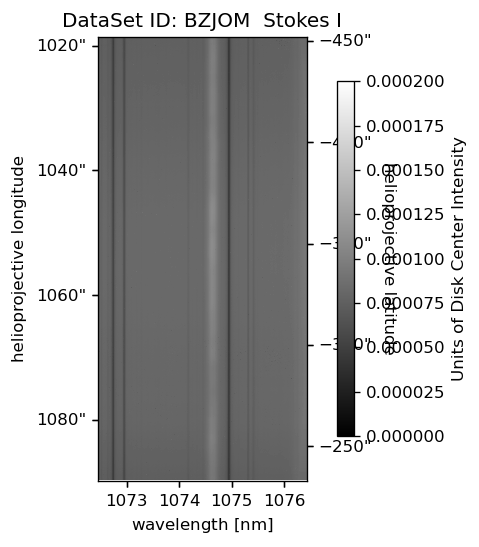

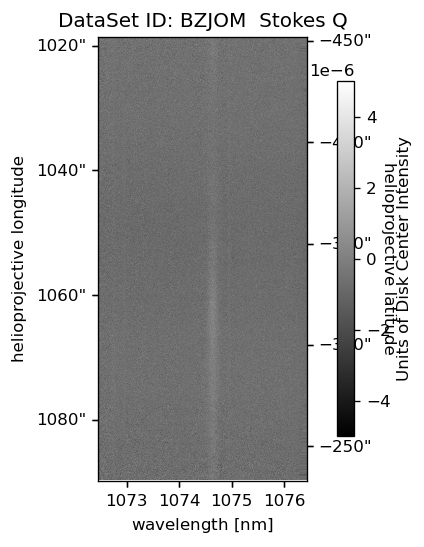

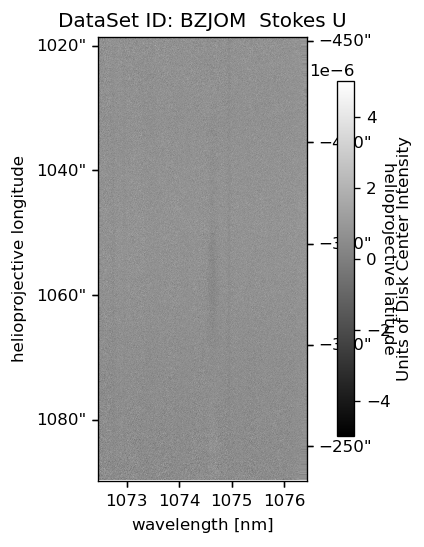

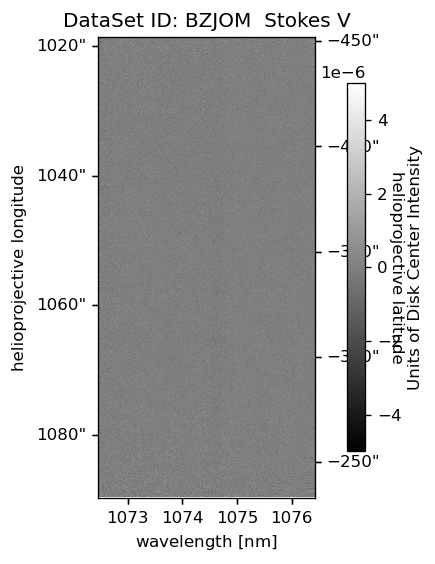

In [19]:
## Dataset BZJOM
stokeslst = [0,1,2,3]       ## Stokes I Q U V
stokeslttr=["I", "Q", "U", "V"]
vmn=[0     , -500e-8, -500e-8, -500e-8]
vmx=[200e-6,  500e-8,  500e-8,  500e-8]
scan_step = 30   
measurement_number = 1

plt.figure #(dpi = 120)
with ProgressBar():
    for i in stokeslst:
        plt.figure(dpi = 120)
        ds[i,scan_step,measurement_number,:,:].plot( vmin = vmn[i],vmax = vmx[i])
        plt.colorbar(shrink = 0.8,label = 'Units of Disk Center Intensity')
        plt.title('DataSet ID: '+ds.headers['DSETID'][0]+"  Stokes "+stokeslttr[stokeslst[i]])
plt.tight_layout()
plt.show()

# Q for Alisdair: how does the ds know the actual data? I do need to have it downloaded locally, don't I ?

ASK Tom how to best comment these images (check Alin's video). Remark these are SINGLE images. One needs to sum over the 10 measuements, as well as rebin along the slit. Values are in disk brightness, I think? (200 millionths, etc). I would now show an intensity map of the raster, and leave the coordinates for later. So, following Alin, again. NOTE: how accurate is the wavelength scale for Cryo?

### Load an image into memory and plot

In the above examples, the data is never loaded into persistent memory. To do this, as well as other operation, one must call the .compute method of dask. 

In [20]:
nstokes, nscan,nrepeat, nspatial,nwv = ds.data.shape

In [21]:
stokes = 0       ## look only at Stokes I 
scan_step = 25    
measurement_number = 1
ds_crop = ds[stokes,scan_step,measurement_number,:,:]  ## A SINGLE 2D IMAGE 
with ProgressBar():
    data = ds_crop.data[:].compute()   ######### HERE WE CALL COMPUTE TO GET THE DATA FROM THE DASK INTO MEMORY 
    y,x = np.indices(ds_crop.data.shape)
    coords = ds_crop.wcs.pixel_to_world(x.flatten(),y.flatten())
    for n in range(len(coords)): 
        coords[n] = coords[n].reshape(y.shape)  

[########################################] | 100% Completed | 116.06 ms


Check that the data dimensions are compatible with the pointing information.


In [22]:
print("Data Shape:         ",data.shape),
print("Wave axis shape:    ",coords[0].shape)
print("Spatial Axis shape: ",coords[1].shape)

Data Shape:          (1917, 902)
Wave axis shape:     (1917, 902)
Spatial Axis shape:  (1917, 902)


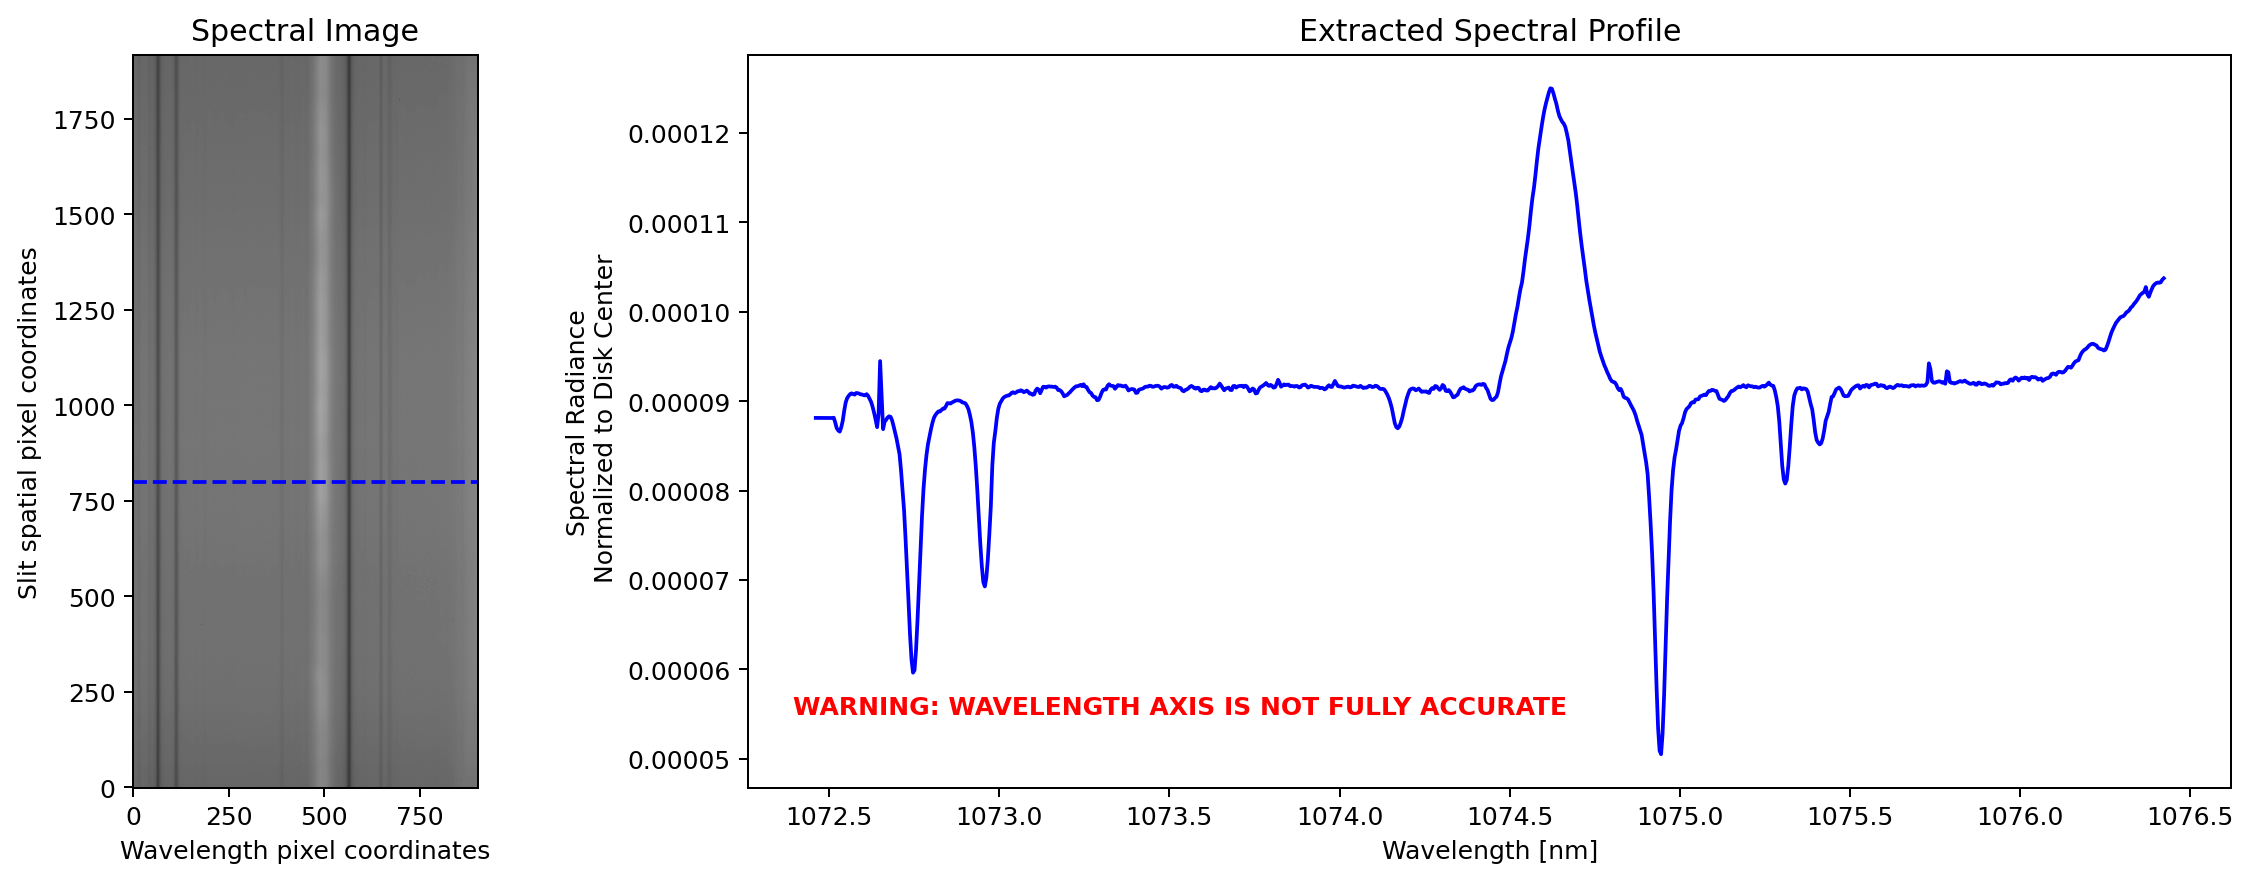

In [23]:
fig,ax = plt.subplots(1,2,figsize = (13,5),width_ratios=[0.3,0.7])
ax = ax.flatten()

yp = 800

ax[0].imshow(data,vmin = 0,vmax = 200e-6)
ax[0].axhline(yp,ls = 'dashed',color = 'blue')
ax[0].set_title("Spectral Image")
ax[0].set_xlabel("Wavelength pixel coordinates")
ax[0].set_ylabel("Slit spatial pixel coordinates")

ax[1].plot(coords[0][yp,:].value,data[yp,:],color = 'blue')
ax[1].set_title("Extracted Spectral Profile")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_ylabel("Spectral Radiance\n Normalized to Disk Center")
ax[1].text(0.03,0.1,'WARNING: WAVELENGTH AXIS IS NOT FULLY ACCURATE',fontweight = 'bold',color = 'red',transform = ax[1].transAxes)

fig.tight_layout()
plt.show()

#Q ask Alisdair if the wavelength is now well defined or not. Also, are the telluric lines removed, in newer data? Then discuss, in the plot

The image & spectrum help identify the wavelengths we might want to use to build a raster image, AND the ones we need to use to subtract the background! (which depends a lot on the raster step. The closer to the Sun, the larger it is.... (e.g. from 240 millionth to  40-50 ...)

## We could load the full data set into memory (...if we had enough memory!) 

We can opt to load the full data set into system memory, which may make some repeated operations faster.  However, this does not use the distributed workflow capabilities of dask. 
Q for Alisdair! What does this mean? 

In [29]:
ds.data

dask.array<reshape, shape=(4, 51, 10, 1917, 902), dtype=float32, chunksize=(1, 1, 1, 1917, 902), chunktype=numpy.ndarray>

In [24]:
print(f"Total size of dataset is {np.round(ds.data.nbytes/ (1024**3),3)} GB")
print(f"Total system memory  {np.round(psutil.virtual_memory().total/ (1024**3),3)} GB")
print(f"Available free memory  {np.round(psutil.virtual_memory().available/ (1024**3),3)} GB")
if (ds.data.nbytes < psutil.virtual_memory().available): 
    print('===> Dataset will fit in free memory')
    with ProgressBar():
        data = ds.data.compute()  ######### MUST CALL COMPUTE TO GET THE DATA FROM THE DASK 
else: 
    print('===> Dataset will NOT fit in free memory')
#   raise ValueError('--- STOP ---')

Total size of dataset is 13.141 GB
Total system memory  32.0 GB
Available free memory  5.59 GB
===> Dataset will NOT fit in free memory


## Since we don't .... 

Let's do a quick figure of the scan, without loading all data in memory

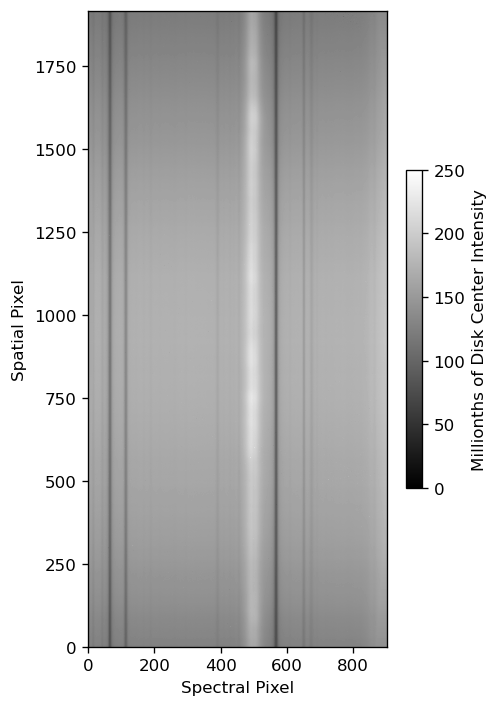

CPU times: user 224 ms, sys: 71.6 ms, total: 296 ms
Wall time: 338 ms


In [25]:
%%time
stokes = 0       ## Stokes I 
scan_step = 10     
measurement_number = 1
data_crop=ds[stokes,scan_step,measurement_number,:,:].data.compute()*1e6 

plt.figure(figsize = (4,6),dpi = 120)
plt.imshow(data_crop,vmin = 0,vmax = 250)
plt.xlabel("Spectral Pixel")
plt.ylabel("Spatial Pixel")
plt.colorbar(shrink = 0.5,label = 'Millionths of Disk Center Intensity')
plt.tight_layout()
plt.show()

Now, let's create a map of the spatial image covered by the raster scan.  We take a median of values in the background continuum to start, near spectral pixels 220 to 260. 

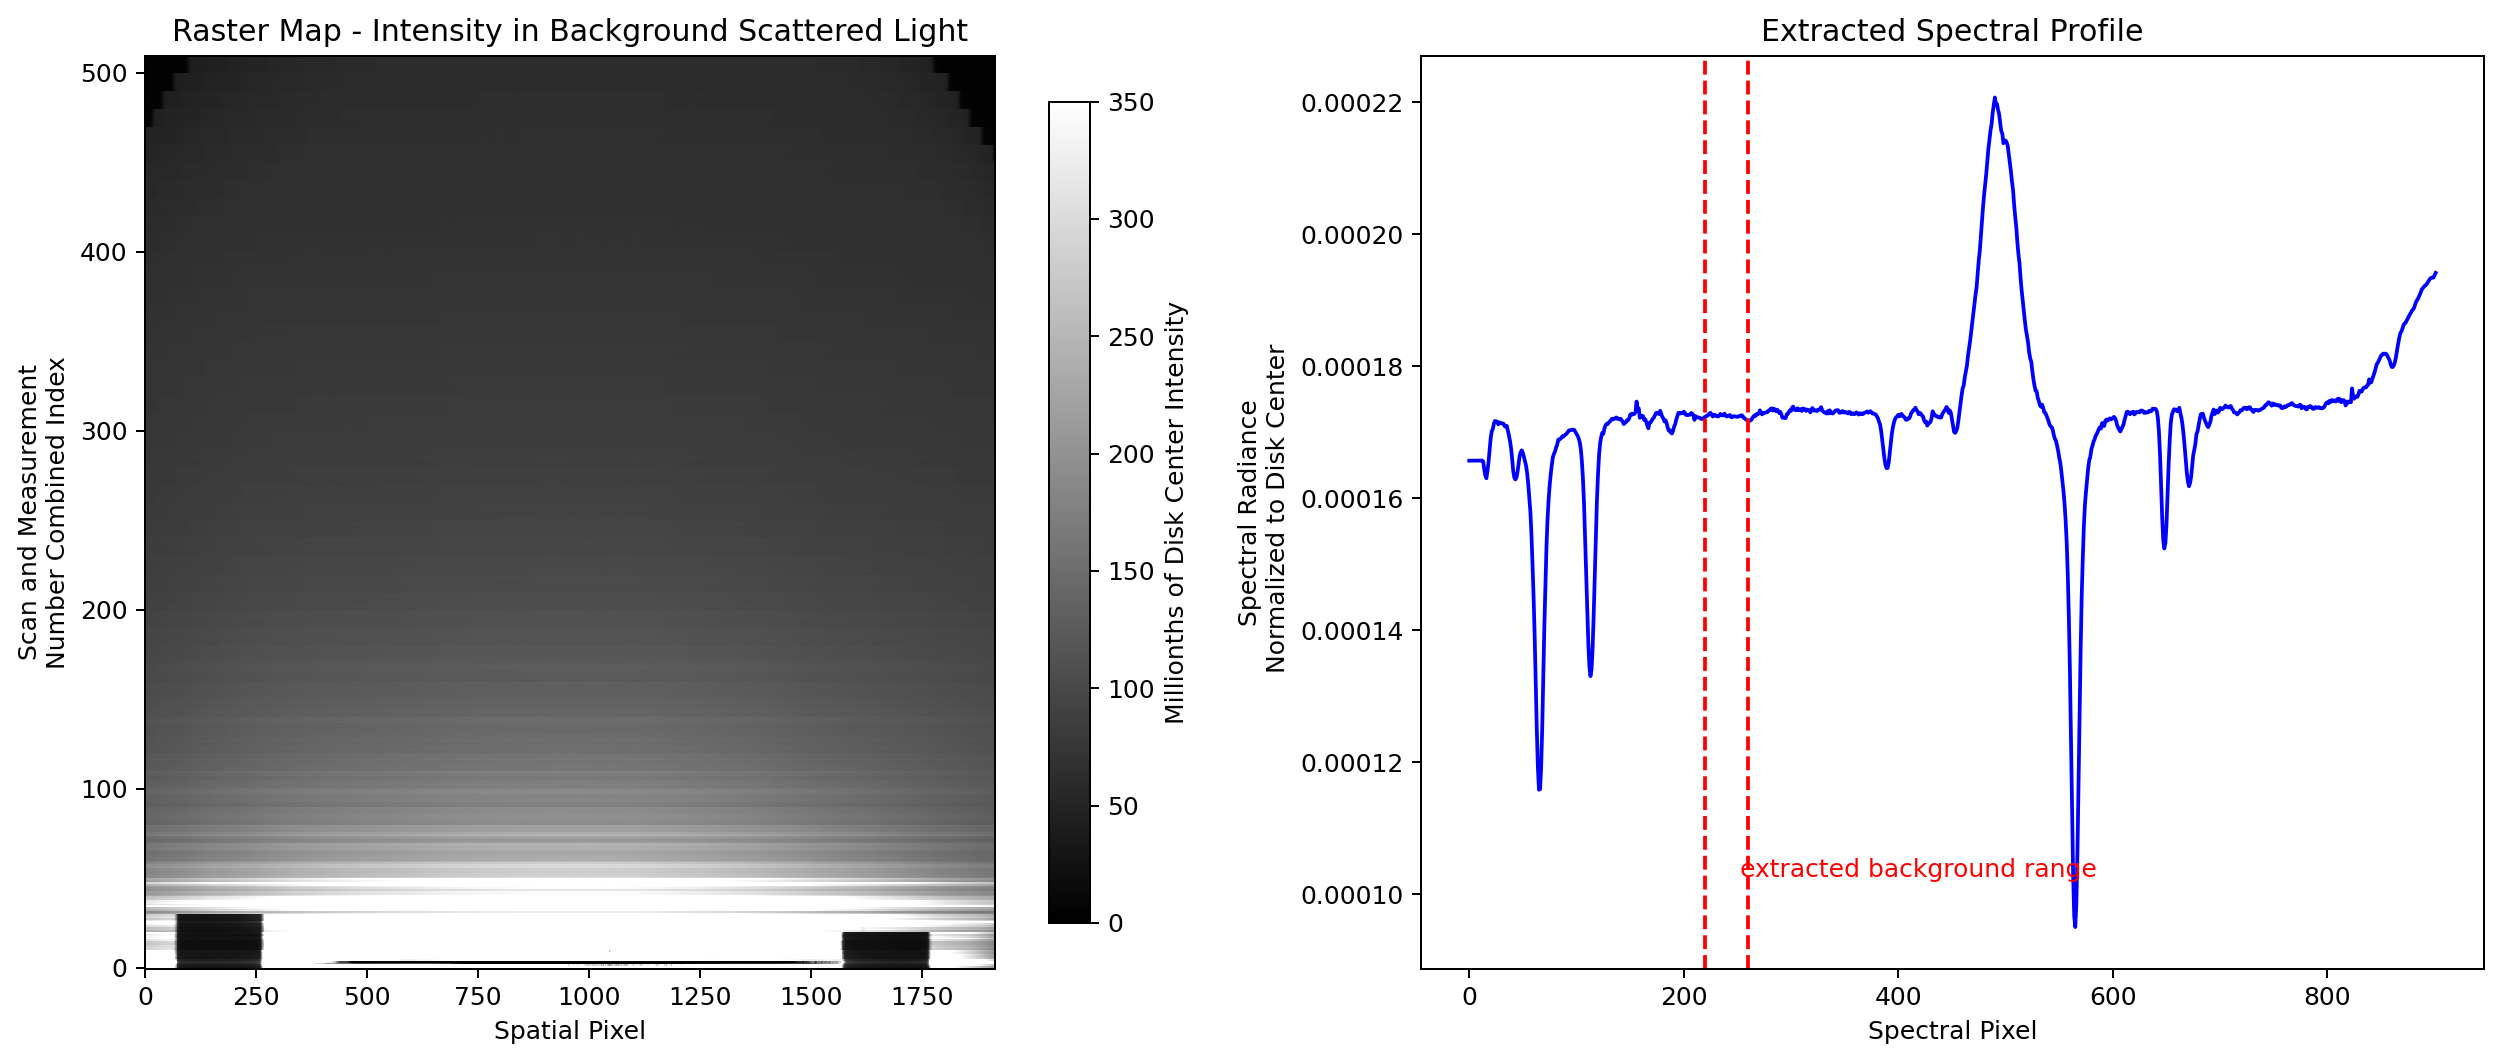

CPU times: user 13 s, sys: 2 s, total: 15 s
Wall time: 8.09 s


In [27]:
%%time
stokes = 0       ## Stokes I only
scan_step = 10     
measurement_number = 1
yp=850

imgBackground = np.nanmedian(ds.data[stokes,:,:,:,220:260].compute(),axis = 3) * 1e6
imgBackground = imgBackground.reshape(nscan*nrepeat,nspatial) 

fig,ax = plt.subplots(1,2,figsize = (14,6),width_ratios=[0.5,0.5])
ax = ax.flatten()

aa=ax[0].imshow(imgBackground ,vmin = 0,vmax = 350,aspect='auto')
ax[0].set_ylabel("Scan and Measurement\nNumber Combined Index")
ax[0].set_xlabel("Spatial Pixel")
fig.colorbar(aa,shrink = 0.9,label = 'Millionths of Disk Center Intensity',ax=ax[0])
ax[0].set_title("Raster Map - Intensity in Background Scattered Light") 

ax[1].plot(ds.data[stokes,scan_step,measurement_number,yp,:].compute(),color = 'blue')
ax[1].set_title("Extracted Spectral Profile")
ax[1].set_xlabel("Spectral Pixel")
ax[1].set_ylabel("Spectral Radiance\n Normalized to Disk Center")
ax[1].axvline(220,ls = 'dashed',color = 'red')
ax[1].axvline(260,ls = 'dashed',color = 'red')
ax[1].text(0.3,0.1,'extracted background range',color = 'r',transform = ax[1].transAxes)

plt.tight_layout()
plt.show()

In [38]:
# discuss the image a bit. The y-axis is a combination of the repeat meas. and the raster scan. The fact that the pattern of background
# is essentially horizontal, tells us that the slit is parallel to the limb. The dark squares are parts of the occulter


Similarly, let's do an image within the coronal line and subtract the background for a quicklook of the coronal intensity-gram

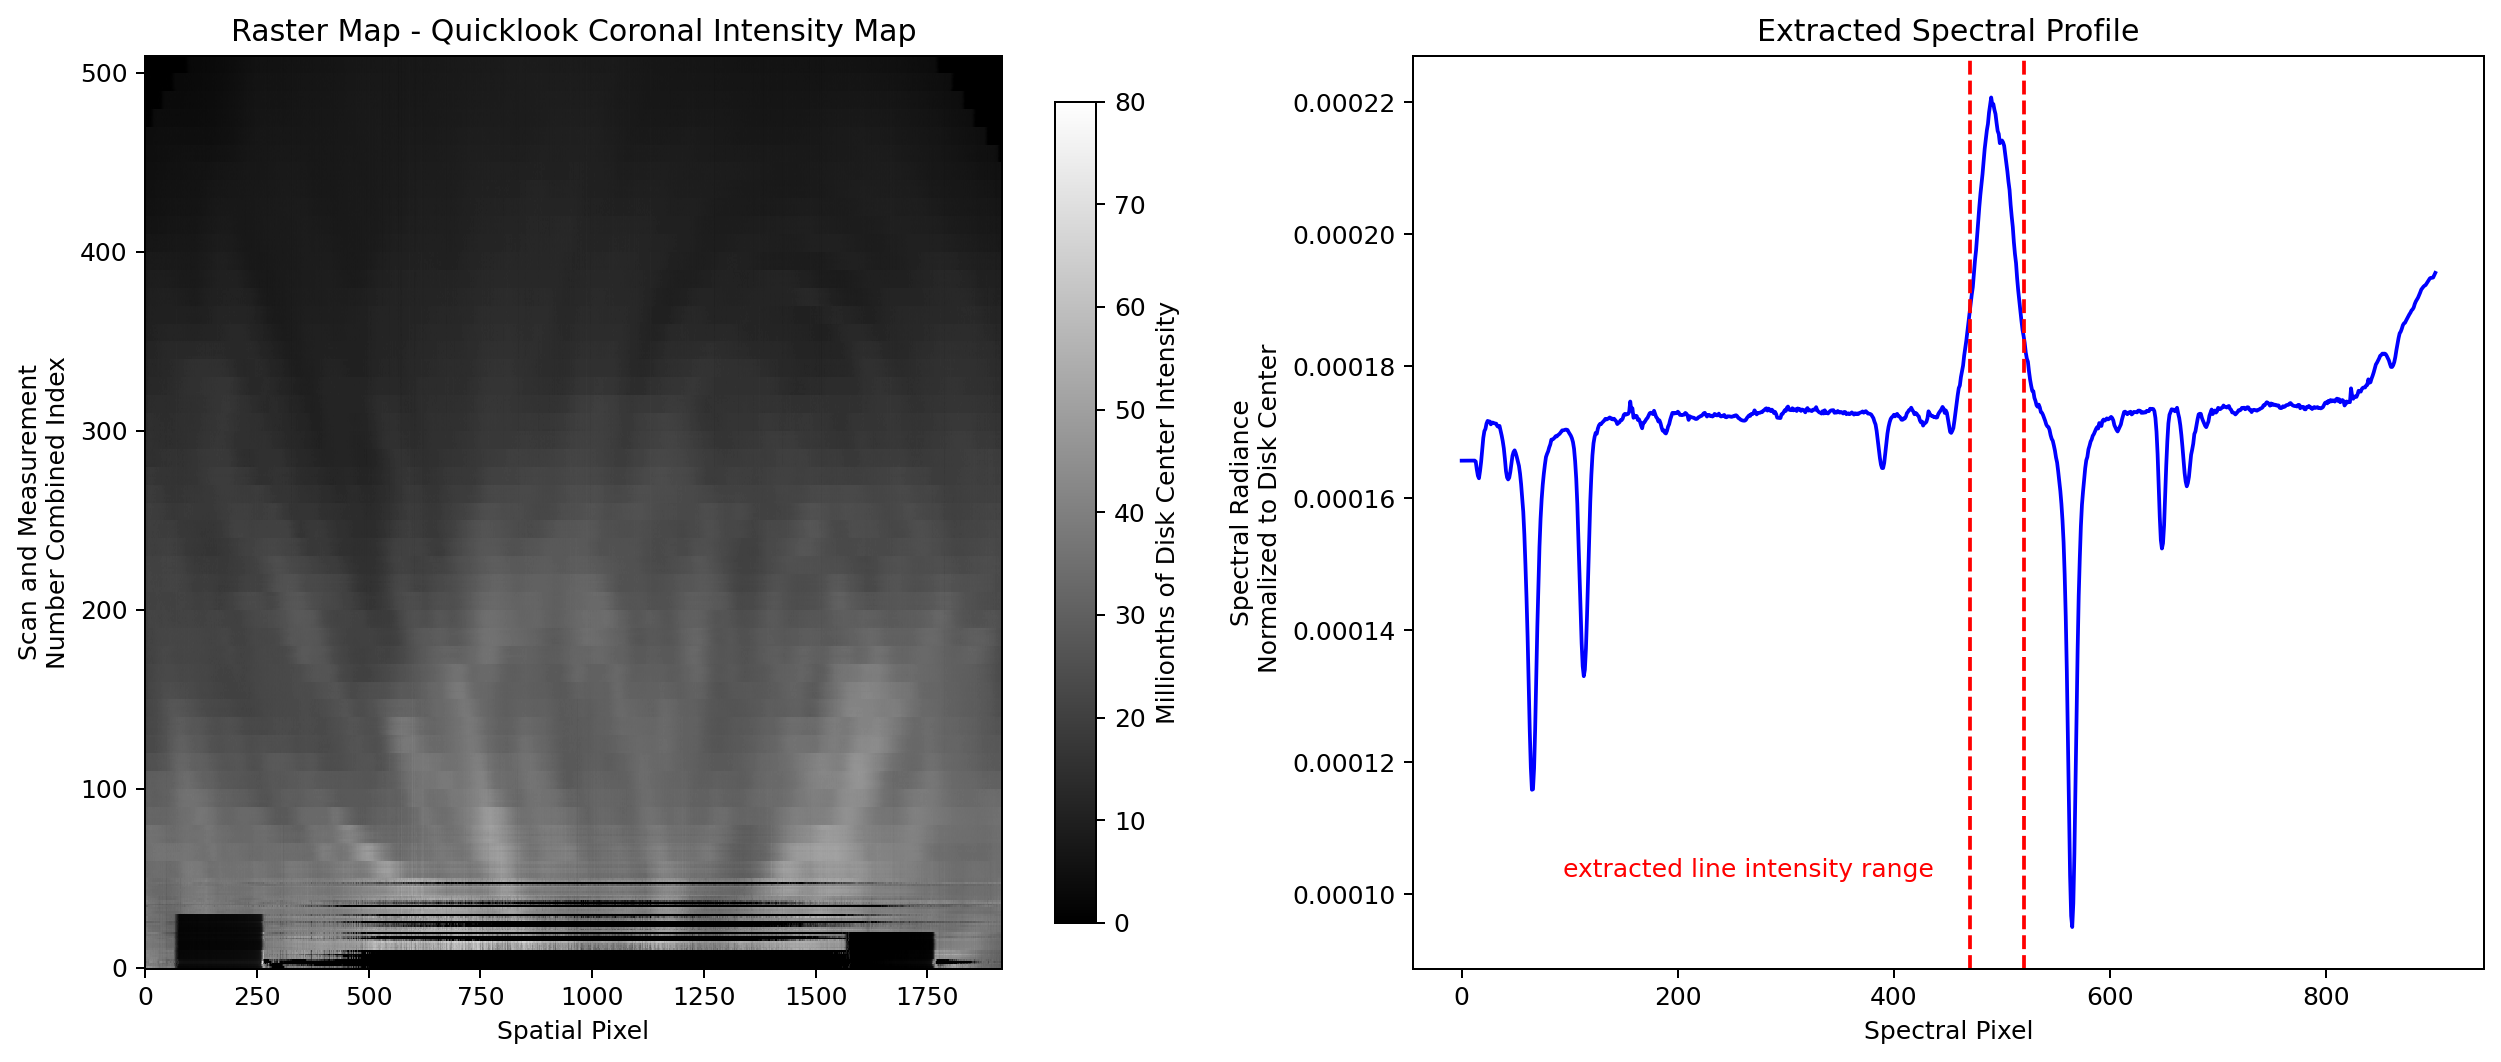

CPU times: user 13.2 s, sys: 1.95 s, total: 15.2 s
Wall time: 8.17 s


In [28]:
%%time
stokes = 0      ## Stokes I 
scan_step = 10     
measurement_number = 1
yp=850

imgLine = np.nanmedian(ds.data[stokes,:,:,:,470:520].compute(),axis = 3) * 1e6
imgLine = imgLine.reshape(nscan*nrepeat,nspatial)  - imgBackground                    ##Subtract the background


fig,ax = plt.subplots(1,2,figsize = (14,6),width_ratios=[0.5,0.5])
ax = ax.flatten()

aa=ax[0].imshow(imgLine ,vmin = 0,vmax = 80,aspect='auto')
ax[0].set_ylabel("Scan and Measurement\nNumber Combined Index")
ax[0].set_xlabel("Spatial Pixel")
fig.colorbar(aa,shrink = 0.9,label = 'Millionths of Disk Center Intensity',ax=ax[0])
ax[0].set_title("Raster Map - Quicklook Coronal Intensity Map") 

ax[1].plot(ds.data[stokes,scan_step,measurement_number,yp,:].compute(),color = 'blue')
ax[1].set_title("Extracted Spectral Profile")
ax[1].set_xlabel("Spectral Pixel")
ax[1].set_ylabel("Spectral Radiance\n Normalized to Disk Center")
ax[1].axvline(470,ls = 'dashed',color = 'red')
ax[1].axvline(520,ls = 'dashed',color = 'red')
ax[1].text(0.14,0.1,'extracted line intensity range',color = 'r',transform = ax[1].transAxes)

plt.tight_layout()
plt.show()

## Let's see where the region is ! 

The previous images did not tell us how large is the FOV, if x (slit) and y (raster) pixels are equal (they are NOT), etc. So let's now follow Tom's notebook from Sept 2024

In [29]:
dataset_directory = '/Users/gcauzzi/DKIST/workshops/SPD_2025/tutorials/CRYO-NIRSP/BZJOM/'

L1_filenames = glob.glob(dataset_directory + '*_I_*.fits')
L1_filenames.sort()  ## sorting using the time stamps

print(f"There are {len(L1_filenames)} L1 Intensity FITS files within the directory")
print(f"first filename: {os.path.basename(L1_filenames[0])}")
print(f"last filename:  {os.path.basename(L1_filenames[-1])}")

There are 510 L1 Intensity FITS files within the directory
first filename: CRYO-NIRSP_SP_2024_03_23T23_08_23_682_01074700_I_BZJOM_L1.fits
last filename:  CRYO-NIRSP_SP_2024_03_24T00_11_58_296_01074700_I_BZJOM_L1.fits


### Load all headers to extract some information about the dataset as a whole

In [30]:
## GET ALL HEADERS
hdrs = []
for n in trange(len(L1_filenames)):
    hdrs.append(fits.getheader(L1_filenames[n],ext=1))

# Note, these are headers only for the I fits files. Q, U, V are identical apart from  

  0%|          | 0/510 [00:00<?, ?it/s]

In [45]:
print(hdrs[15].keys) #scan position changes only after 10 files

<bound method Header.keys of XTENSION= 'IMAGE   '                                                            
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  902 / [pix]                                          
NAXIS2  =                 1917 / [pix]                                          
NAXIS3  =                    1 / [pix]                                          
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
BUNIT   = 'ct      '                                                            
DATE    = '2024-08-25T04:26:58.357'                                             
DATE-BEG= '2024-03-23T23:10:15.658'                                             
DATE-END= '2024-03-23T23:10:22.861'                                             

In [30]:
#print(len(hdrs)) #number of headers (=files)

510


In [31]:
print(f"Data product information at: {hdrs[0]['HEAD_URL']}") #not sure this is useful

Data product information at: https://docs.dkist.nso.edu/projects/data-products/en/v4.6.0


In [32]:
## Put all of the headers into a dictionary for easier manipulation
hdr_dict = {}
hdr_dict['datetimes'] = np.array([Time(hdr['DATE-AVG']).to_datetime() for hdr in hdrs])  ## datetimes useful for plotting
for key in hdrs[0].keys():
    if key =='COMMENT' or key == '': continue  ## do not include comments and black header cards
    hdr_dict[key] = np.empty(len(hdrs),dtype = 'O')
    for n in range(len(hdrs)):  hdr_dict[key][n] = hdrs[n][key] 


In [33]:
#print(hdrs[0].keys)
print(len(hdr_dict))  #number of "keys" in each FITS header (comments removed)

359


## Determine data cube size¶

In [34]:
## Show information on 1st and 2nd direction scanning (step size and number; 1^ direction = raster; 2^ = mosaic? ask Tom. Or remove 2^ direction) 
for k in 'CNP1DSS','CNP1DNSP','CNP2DSS','CNP2DNSP',:
    print(hdrs[0][k+'*'])

if os.path.exists(L1_filenames[0].replace('_I_','_Q_')): 
    n_stokes = 4
else: 
    n_stokes = 1

#n_scanSteps  = np.max(np.array([hdr['CNCURSCN'] for hdr in hdrs])) #CN CUR(rent) SCN (scan) = the current scan position
n_scanSteps  = hdrs[0]['CNNUMSCN']
# but why not use key CNNUMSCN ? or DNAXIS4 ? GC

#n_measAtStep = np.max(np.array([hdr['CNCMEAS'] for hdr in hdrs])) #CN C(urrent) MEA(surement) S(tep) - can vary from 1 to ?? Here its is 10
n_measAtStep = hdrs[0]['DNAXIS3']
# but why not use DNAXIS3 ? GC

n_wv         = hdrs[0]['NAXIS1']
n_alongSlit  = hdrs[0]['NAXIS2']
data_shape   = (n_stokes,n_scanSteps,n_measAtStep,n_alongSlit,n_wv)
print("Data Shape: ",data_shape,' (n_stokes,n_scanSteps,n_measAtStep,n_alongSlit,n_wv)')  

## Note that this matches the asdf data shape above. 

CNP1DSS =                  4.0 / PriScan1stDirStepSize                          END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [58]:
# CN p1 d size step = 4"; CN p1 number of steps = 51

## Get spectral and spatial coordinates

* As of the first data release, the CryoNIRSP spectral and spatial world coordinates in the Level 1 data include corrections applied at the time of calibration. Both can still have errors and should be verified manually as necessary and possible. 
* The spectral coordinates are determined using an atlas model fit to the flat field spectra acquired at disk center, and does account for Sun-Earth orbital motions. However, in some cases, the spectra may be shifted in the science data compared to the flat field data, which leads to issues in the metadata. This occurs in particular when there are spectrograph configuration changes between the flat field and the science data.
* The spatial coordinates may have inaccuracies of up to ~15 to 20 arcseconds, and there is some non-uniformity in the step width of the image scanning mirror. These can be as large as an arcsecond.


In [35]:
########### GET SPECTRAL DISPERSION AXIS 
## Use the WCS tools for this as the dispersion axis is not strictly linear
## the spectral dispersion axis type (CTYPE1) is 'AWAV-GRA' refers to a grating func for air wavelengths                                                          
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  ## TO ELIMINATE datafix warnings 
    wcs = WCS(hdrs[0])
    nwv = hdrs[0]['NAXIS1']
    specCoords = wcs.array_index_to_world(0,0,np.arange(nwv))[0].to(u.nm).value

In [36]:
hpxyCoords = np.zeros((2,n_scanSteps,n_measAtStep,n_alongSlit))
timeCoords = np.zeros((n_scanSteps,n_measAtStep),dtype ='datetime64[ms]')
#hpxyCoords.shape
#timeCoords

######### GET ALL SPATIAL COORDINATES 
## Here multiprocessing is used.  There may be other ways to accelerate 

def work(argin):    
    """ function defining what work is carried out by the parallel process """ 
    n = argin   ## the filter index number n
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  ## TO ELIMINATE datafix warnings 
        wcs = WCS(hdrs[n])
        xy = wcs.array_index_to_world(0,np.arange(n_alongSlit),0)[1]
        x,y,obstime = xy.Tx.value,xy.Ty.value,xy[0].obstime
    ## return current scan step number, current measurement number, 
    ## Tx and Ty helioprojective coordinates, and the observation time. 
    return hdrs[n]['CNCURSCN'],hdrs[n]['CNCMEAS'],x,y, obstime.to_datetime()  

ncpus = min(multiprocessing.cpu_count() , 40)
p     = multiprocessing.Pool(processes=ncpus,maxtasksperchild = 1000)
arg_array = list(range(len(hdrs)))
rs    = p.imap(work,arg_array)
p.close()

hpxyCoords = np.zeros((2,n_scanSteps,n_measAtStep,n_alongSlit))
timeCoords = np.zeros((n_scanSteps,n_measAtStep),dtype ='datetime64[ms]')
pbar = tqdm(total=len(arg_array),position = 0, leave = True)
for i,res in enumerate(rs):
    CNCURSCN,CNCMEAS,x,y,obstime = res 
    hpxyCoords[0,CNCURSCN-1,CNCMEAS-1,:] =  x
    hpxyCoords[1,CNCURSCN-1,CNCMEAS-1,:] =  y
    timeCoords[CNCURSCN-1,CNCMEAS-1] = obstime
    pbar.update()
pbar.close()

### GC: 

the above cell does not work for me, there is some conflicts with the multiprocessing. So I tried to follow an example by Alin (here below), but it does not seem to work as intended, either. 

Maybe a stupid question, but for a first look at where the FOV is, why don't we use the Bounding Box as reported in the ASDF file? [(1161.51,-198.53),(912.14,-475.24) for this data set]

## How to extract the coordinate values of the above image with the lower level WCS information 
(from Alin - but it does not plot what I want)

In [75]:
stokes = 0
ds_crop = ds[stokes,scan_step,measurement_number,:,:]  ## crop single image 
y,x = np.indices(ds_crop.data.shape)  ##  get index arrays for this image 
coords = ds_crop.wcs.pixel_to_world(x.flatten(),y.flatten()) ## get coordinates 
for n in range(len(coords)): 
    coords[n] = coords[n].reshape(y.shape)    

print(' Coordinate 0 (Wavelength) for corner pixel: ',coords[0][0,0])
print(' Coordinate 1 (Lon, Lat) for corner pixel: ',coords[1][0,0])

 Coordinate 0 (Wavelength) for corner pixel:  1072.4604872221971 nm
 Coordinate 1 (Lon, Lat) for corner pixel:  <SkyCoord (Helioprojective: obstime=2024-03-23T23:40:18.292, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2024-03-23T23:40:18.292, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00096773, -6.90468254, 1.49133473e+11)>): (Tx, Ty) in arcsec
    (1089.69850057, -233.12592437)>


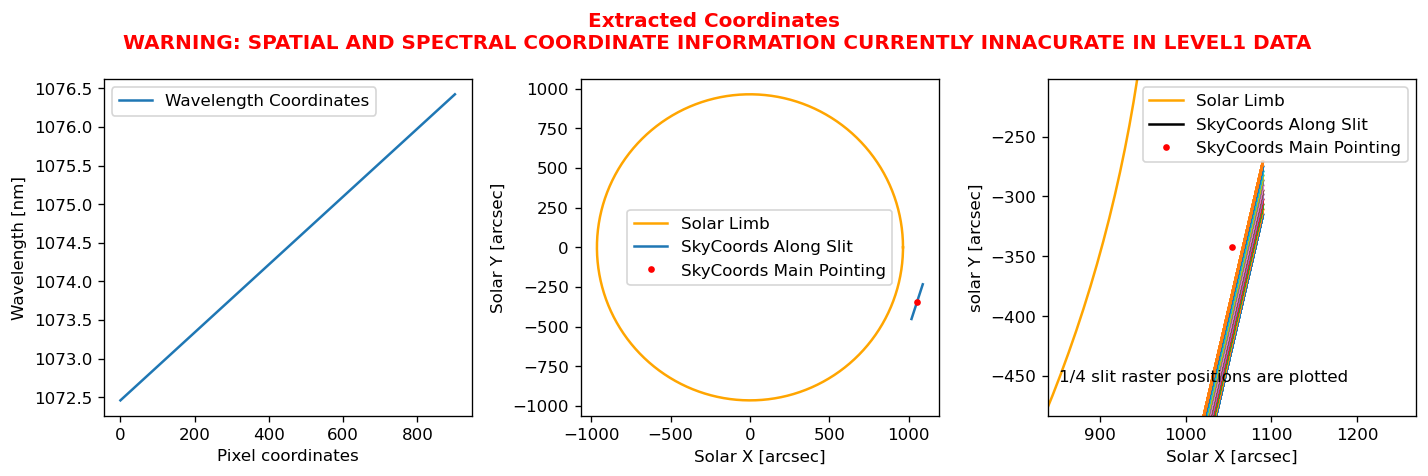

In [76]:
fig,ax = plt.subplots(1,3,figsize = (12,4),dpi = 120)
ax = ax.flatten()
ax[0].plot(coords[0][0,:].value,label = 'Wavelength Coordinates')
ax[0].set_ylabel("Wavelength [nm]")
ax[0].set_xlabel("Pixel coordinates")
ax[0].legend()

th = np.linspace(0,2.*np.pi,300)
ax[1].plot(965.*np.cos(th),965.*np.sin(th),color="orange",label="Solar Limb")
ax[1].plot(coords[1][:,0].Tx.value,coords[1][:,0].Ty.value,label = 'SkyCoords Along Slit')
ax[1].plot(coords[1][np.int16(ds.headers[0]["DNAXIS2"]/2),0].Tx.value,coords[1][np.int16(ds.headers[0]["DNAXIS2"]/2),0].Ty.value,'.',markersize =6,color="r",label = 'SkyCoords Main Pointing')
ax[1].legend()
ax[1].set_aspect(1)
ax[1].set_xlabel("Solar X [arcsec]")
ax[1].set_ylabel("Solar Y [arcsec]")

fig.suptitle('Extracted Coordinates\nWARNING:  COORDINATE INFORMATION NOT FULLY CORRECT IN LEVEL1 DATA' + 
             '\nSlit orientation may also be incorrect',color = 'r',fontweight = 'bold') 


##adding the raster location example
ax[2].plot(965.*np.cos(th),965.*np.sin(th),color="orange",label="Solar Limb")
ax[2].plot(coords[1][0,0].Tx.value,coords[1][0,0].Ty.value,label = 'SkyCoords Along Slit',color="k")
ax[2].plot(coords[1][np.int16(ds.headers[0]["DNAXIS2"]/2),0].Tx.value,coords[1][np.int16(ds.headers[0]["DNAXIS2"]/2),0].Ty.value,'.',markersize =6,color="r",label = 'SkyCoords Main Pointing')
ax[2].text(0.03,0.1,'1/4 slit raster positions are plotted',color = 'k',transform = ax[2].transAxes)


for m in range(np.int16(ds.headers[0]["DNAXIS4"]/4)):    
    n=ds.headers[0]["DNAXIS3"]
    ax[2].plot(coords[1][:,0].Tx.value,coords[1][:,0].Ty.value+ ds.headers[m*n]['CNP1DSRT'] +ds.headers[m*n]['CNP1DSS']*ds.headers[m*n]['CNP1DCUR'],'.',markersize =1)


ax[2].set_xlabel("Solar X [arcsec]")
ax[2].set_ylabel("solar Y [arcsec]")
ax[2].set_xlim(coords[1][0,0].Tx.value-250,coords[1][-1,0].Tx.value+250)
ax[2].set_ylim(coords[1][0,0].Ty.value-250,coords[1][-1,0].Ty.value+250)
ax[2].legend()
#ax[2].set_aspect(1)

fig.suptitle('Extracted Coordinates\n WARNING: SPATIAL AND SPECTRAL COORDINATE INFORMATION CURRENTLY INNACURATE IN LEVEL1 DATA',weight='bold') 
fig.tight_layout()

fig.tight_layout()
plt.show()